In [1]:
!pip install evaluate

import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
!pip install datasets

In [ ]:
!pip install --upgrade --force-reinstall transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

**output.csv로 fine-tuning**

In [ ]:
# 1. 라이브러리 설치
import os
os.environ["WANDB_DISABLED"] = "true"

# 2. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 3. pandas 데이터 불러오기 및 라벨 0~4 변환
import pandas as pd
df = pd.read_csv('/content/Train_set.csv')
df['label'] = df['label'] - 1    # 1~5 → 0~4로 변환 (중요!)
df['label'] = df['label'].astype(int)
print("라벨 유니크값:", sorted(df['label'].unique()))  # [0, 1, 2, 3, 4]만 나오면 OK

# 4. 데이터 내용 확인
print(df.head())

# 5. 데이터셋 train/valid 분할 (8:2 예시)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# 6. Huggingface 데이터셋 변환
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# 7. KcBERT 토크나이저/모델 준비
from transformers import BertTokenizer, BertForSequenceClassification
model_name = 'beomi/kcbert-base'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)  # 반드시 5로!

# 8. 토크나이즈 함수 정의
def preprocess_function(examples):
    return tokenizer(examples['문장'], truncation=True, padding='max_length', max_length=64)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

# Huggingface Trainer용 포맷으로 정리
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])

# 9. Trainer로 파인튜닝
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model='eval_loss',
    save_strategy="epoch"
)

# 평가 지표 (여기선 accuracy)
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# 10. 최종 모델 저장 (구글드라이브에 백업)
output_dir = '/content/drive/MyDrive/kcbert_self_finetuned4'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("파인튜닝 완료! 모델이 구글드라이브에 저장되었습니다.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
라벨 유니크값: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
                                                파일명  \
0          제네시스 GV80, 절반의 합격점. 좋은데 부담스러운 첨단 기능.docx   
1          제네시스 GV80, 절반의 합격점. 좋은데 부담스러운 첨단 기능.docx   
2     [시승기] '보급형 랜드로버 느낌' 부활 신호에서 확신으로 쌍용차 토레스.docx   
3     [시승기] '보급형 랜드로버 느낌' 부활 신호에서 확신으로 쌍용차 토레스.docx   
4  [시승기] 제네시스 첫 전용 전기차 GV60 '후두부를 강타하는 기막힌 반전'.docx   

                                                  문장  label  
0  필기 인식의 손글씨 입력을 통해 사용되지만 대시보드 상단 대형 디스플레이를 통해 대...      2  
1  다만 입체적 패턴과 화려함을 전달했던 디지털 계기판과 다양한 정보와 시인성 높은 헤...      4  
2  계기판은 앞서 티볼리와 코란도를 통해 봐왔던 3분할 디지털 클러스터가 적용되고 대신...      3  
3  센터페시아 상단에는 12.3인치 터치식 디지털 디스플레이가 자리하고 또 그 아래에는...      2  
4  이 밖에 실내에선 아이오닉 5를 통해서도 봤던 디지털 계기판과 센터 디스플레이를 파...      4  


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

<ipython-input-8-113445578>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values,palette='Set2')


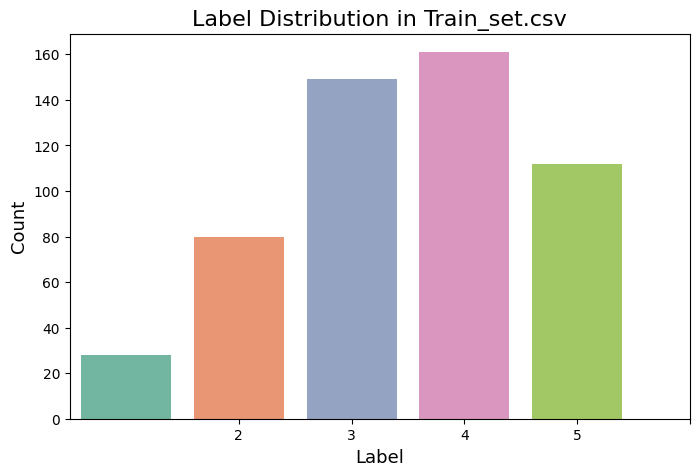

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv('/content/Train_set.csv')

label_col = 'label'  # 실제 컬럼명 넣어주세요

# 라벨 카운트
label_counts = df[label_col].value_counts().sort_index()

# Barplot (palette 없이, 영어 제목/축, 한글 미사용)
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values,palette='Set2')
plt.title('Label Distribution in Train_set.csv', fontsize=16)
plt.xlabel('Label', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(label_counts.index)
plt.show()

In [ ]:
# 1. 설치
!pip install transformers datasets scikit-learn pandas tqdm evaluate

import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import evaluate

# 2. 데이터 불러오기
df = pd.read_csv('/content/Train_set.csv')

# 라벨 정수화(혹시 1~5라면 0~4로, 이미 0~4면 아래 두 줄 생략)
# df['label'] = df['label'] - 1
# df['label'] = df['label'].astype(int)

print(df['label'].value_counts().sort_index())
print(df.head())

# 3. Stratified sampling으로 train/val 분할 (예: 8:2)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],   # 라벨 분포 비율 유지
    random_state=42
)
print('Train:', train_df['label'].value_counts().sort_index())
print('Val:', val_df['label'].value_counts().sort_index())

# 4. Huggingface Dataset 객체로 변환
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# 5. 토크나이저/모델 준비
model_ckpt = "beomi/kcbert-base"
num_labels = df['label'].nunique()

tokenizer = BertTokenizer.from_pretrained(model_ckpt)
model = BertForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

# 6. 토크나이즈 함수
def preprocess(examples):
    return tokenizer(examples['문장'], truncation=True, padding='max_length', max_length=64)

train_dataset = train_dataset.map(preprocess, batched=True)
val_dataset = val_dataset.map(preprocess, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

# 7. Trainer & TrainingArguments
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_metric.compute(predictions=preds, references=p.label_ids)
    f1 = f1_metric.compute(predictions=preds, references=p.label_ids, average='weighted')
    acc['f1'] = f1['f1']
    return acc

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 8. 파인튜닝 실행
trainer.train()

# 9. 최종 모델 저장
save_path = "/content/drive/MyDrive/kcbert_finetuned_stratified"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("최종 튜닝 모델이 저장되었습니다: ", save_path)

# 10. 성능 평가 결과 출력
eval_result = trainer.evaluate(val_dataset)
print('\n=== Validation 성능 측정 결과 ===')
for k,v in eval_result.items():
    if k.startswith('eval_'):
        print(f'{k}: {v:.4f}')

ImportError: cannot import name 'PreTrainedModel' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

In [ ]:
!pip install --upgrade --no-cache-dir transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 286.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
import numpy as np
if not hasattr(np, "dtypes"):
    np.dtypes = np.dtype  # 임시로 dtypes를 dtype과 동치로 바인딩

In [ ]:
import transformers, datasets, evaluate
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

In [ ]:
import transformers
print(transformers.PreTrainedModel)
print(transformers.PreTrainedModel.__module__)

import numpy as np
print(np.__version__)

AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:
import numpy as np
print(hasattr(np, "dtype"))    # True
print(hasattr(np, "dtypes"))   # False

True
False


**튜닝된 KcBERT 성능평가**

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1. 모델/토크나이저 로드
model_path = '/content/drive/MyDrive/kcbert_self_finetuned3'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# 2. 평가 데이터 로드
df = pd.read_csv('/content/reviews.csv')  # or 검증/테스트 데이터셋
texts = df['문장'].tolist()
labels_true = df['문장'].tolist()

# 3. 예측
preds = []
with torch.no_grad():
    for text in texts:
        inputs = tokenizer(str(text), return_tensors='pt', truncation=True, padding=True, max_length=64)
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        preds.append(pred)

# 4. 평가지표 계산
acc = accuracy_score(labels_true, preds)
f1 = f1_score(labels_true, preds, average='weighted')
report = classification_report(labels_true, preds)
conf = confusion_matrix(labels_true, preds)

print('정확도(Accuracy):', acc)
print('F1 score:', f1)
print('\n=== 분류 리포트 (precision/recall/F1) ===\n', report)
print('\n=== 혼동행렬(Confusion Matrix) ===\n', conf)

ValueError: Mix of label input types (string and number)

**output.csv로 튜닝된 KcBERT로 감성분석**

In [ ]:
# 1. 필수 라이브러리
!pip install -q transformers python-docx kss

# 2. 워드파일 업로드
from google.colab import files
uploaded = files.upload()
docx_filename = list(uploaded.keys())[0]
DOCX_PATH = f"/content/{docx_filename}"

# 3. 문단→문장 분리
from docx import Document
import kss

doc = Document(DOCX_PATH)
all_paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
all_sents = []
for para in all_paragraphs:
    sents = kss.split_sentences(para)
    all_sents.extend([s.strip() for s in sents if s.strip()])

# 4. 키워드 세팅
cd_keywords = ['클러스터', '계기판', '디스플레이']
attribute_keywords = {
    '가독성': ['가독성', '읽기', '잘보인다', '선명', '시인성'],
    '크기': ['크기', '크다', '작다', '화면크기', '작음', '넓다', '좁다'],
    '정보량': ['정보량', '정보', '많다', '적다', '복잡', '혼란'],
    '계기판': ['계기판'],
    '속도계': ['속도계', '속도'],
    '밝기': ['밝기', '밝다', '어둡', '조명'],
    '위치': ['위치', '배치', '시야', '운전 중 보이기', '손이 닿', '시야확보'],
    '디자인': ['디자인', '예쁘', '세련', '고급', '심플', '이쁘']
}

# 5. 클러스터/디스플레이 + 속성 필터 & 키워드 추출
filtered_lines = []
matched_attributes = []
matched_keywords = []

for sent in all_sents:
    if any(cd in sent for cd in cd_keywords):
        this_attrs = []
        this_kwlist = []
        for attr, kws in attribute_keywords.items():
            for kw in kws:
                if kw in sent:
                    this_attrs.append(attr)
                    this_kwlist.append(kw)
        if this_attrs:
            filtered_lines.append(sent)
            matched_attributes.append(list(set(this_attrs)))
            matched_keywords.append(list(set(this_kwlist)))

# 6. 튜닝된 KcBERT 로딩 & 감성분석
finetuned_model_path = '/content/drive/MyDrive/kcbert_self_finetuned3'
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained(finetuned_model_path, local_files_only=True)
model = BertForSequenceClassification.from_pretrained(finetuned_model_path, local_files_only=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

label_map = {0: "매우 부정", 1: "부정", 2: "중립", 3: "긍정", 4: "매우 긍정"}
scale = [1, 2, 3, 4, 5]   # "매우 부정~매우 긍정" 스케일

def predict_sentiment_with_score(sentences, tokenizer, model, batch_size=8):
    results = []
    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=64)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            preds = probs.argmax(axis=1)
            confidences = probs.max(axis=1)
            scores = [float(sum(p*s for p, s in zip(prob, scale))) for prob in probs]
            results.extend(list(zip(preds, confidences, scores)))
    return results

if filtered_lines:
    preds_scores = predict_sentiment_with_score(filtered_lines, tokenizer, model)
    for sent, (pred, conf, score), attrs in zip(filtered_lines, preds_scores, matched_attributes):
        print(f"""문장: {sent}
감정: {label_map.get(int(pred), str(pred))} | 신뢰도: {conf:.3f} | 감성점수(1~5): {score:.2f} | 속성 키워드: {', '.join(attrs)}
---""")

else:
    print("클러스터/디스플레이 및 속성 관련 문장이 존재하지 않습니다.")

Saving Benz_S580_bobae.docx to Benz_S580_bobae.docx
클러스터/디스플레이 및 속성 관련 문장이 존재하지 않습니다.


**리뷰문장들이 저장돼있는 csv파일을 받아서 감성분석 수행 후 결과 저장 코드**

In [ ]:
# 1. 패키지 설치
!pip install transformers konlpy pandas openpyxl tqdm

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

csv_path = '/content/reviews.csv'
df = pd.read_csv(csv_path)

from transformers import BertTokenizer, BertForSequenceClassification
model_path = '/content/drive/MyDrive/kcbert_self_finetuned3'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

from torch.nn.functional import softmax
from tqdm.notebook import tqdm
import torch
import numpy as np

# 감정 라벨명 매핑 (파인튜닝 라벨과 반드시 일치)
label_names = {0: "매우 부정", 1: "부정", 2: "중립", 3: "긍정", 4: "매우 긍정"}

# [속성 키워드 딕셔너리] 실무형 확장
attribute_keywords = {
    "가독성/시인성": ['가독성', '선명', '시인성', '식별', '판독', '잘보임'],
    "정보구성": ['정보량', '정보', '배치', '간결하다', '복잡', '혼란'],
    "크기": ['크기', '사이즈', '크다', '작다', '넓다', '좁다', '적절', '과하게'],
    "위치/시야": ['위치', '배치', '시야', '운전', '시야확보', '운전 중', '손이 닿다'],
    "디자인": ['디자인', '예쁘', '고급', '심플', '트렌디', '조화'],
    "조작성": ['조작', '직관', '편하다', '터치', '버튼', '쉬움', '사용성'],
    "밝기": ['밝기', '밝다', '어둡', '조명', '야간', '눈부심'],
    "반응속도": ['응답', '지연', '빠르다', '느리다', '딜레이'],
    "내구성/품질감": ['내구성', '품질', '튼튼', '고급소재'],
    "버그/오류": ['오류', '고장', '버그', '멈춤', '오작동']
}

# (복수 출력) 속성 키워드 함수 - 여러 개 걸리면 다 콤마로!
def extract_attribute_keywords(text):
    matched_attrs = []
    for att, keywords in attribute_keywords.items():
        if any(kw in str(text) for kw in keywords):
            matched_attrs.append(att)
    return ",".join(matched_attrs) if matched_attrs else ""

result_emotion = []
result_score = []
result_attribute = []
result_confidence = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['문장']
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True, max_length=64)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.squeeze()
        probs = softmax(logits, dim=-1).detach().cpu().numpy()
        pred = np.argmax(probs)
        confidence = float(np.max(probs))  # 신뢰도(예측 감정의 확실성)
        # 감성점수 (5-class)
        sentiment_score = (probs[4] * 1.0) + (probs[3] * 0.75) + (probs[2] * 0.5) + (probs[1] * 0.25) + (probs[0] * 0.0)

    result_emotion.append(label_names.get(pred, str(pred)))
    result_score.append(float(sentiment_score))
    result_confidence.append(confidence)
    result_attribute.append(extract_attribute_keywords(text))

# 새로운 데이터프레임 생성 (파일명, 문장, 감정, 감성점수, 속성키워드, 신뢰도)
result_df = pd.DataFrame({
    '파일명': df['파일명'],
    '문장': df['문장'],
    '감정': result_emotion,
    '감성점수': result_score,
    '속성키워드': result_attribute,
    '신뢰도': result_confidence
})

save_path = '/content/Sentiment_Analysis_Results.xlsx'
result_df.to_excel(save_path, index=False)
print(f'감성분석 결과가 {save_path}에 저장되었습니다!')

from google.colab import files
files.download(save_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 34.7 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1929 [00:00<?, ?it/s]

감성분석 결과가 /content/Sentiment_Analysis_Results.xlsx에 저장되었습니다!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. 패키지 설치
!pip install transformers konlpy pandas openpyxl tqdm

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

csv_path = '/content/reviews.csv'
df = pd.read_csv(csv_path)

from transformers import BertTokenizer, BertForSequenceClassification
model_path = '/content/drive/MyDrive/kcbert_self_finetuned2'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

from torch.nn.functional import softmax
from tqdm.notebook import tqdm
import torch
import numpy as np

# 감정 라벨명 매핑 (파인튜닝 라벨과 반드시 일치)
label_names = {0: "매우 부정", 1: "부정", 2: "중립", 3: "긍정", 4: "매우 긍정"}

# 키워드 세팅
cd_keywords = ['클러스터', '계기판', '디스플레이']
attribute_keywords = {
    '가독성': ['가독성', '읽기', '잘보인다', '선명', '시인성'],
    '크기': ['크기', '크다', '작다', '화면크기', '작음', '넓다', '좁다'],
    '정보량': ['정보량', '정보', '많다', '적다', '복잡', '혼란'],
    '계기판': ['계기판'],
    '속도계': ['속도계', '속도'],
    '밝기': ['밝기', '밝다', '어둡', '조명'],
    '위치': ['위치', '배치', '시야', '운전 중 보이기', '손이 닿', '시야확보'],
    '디자인': ['디자인', '예쁘', '세련', '고급', '심플', '이쁘'],
    '디스플레이': ['디스플레이']
}


# 속성 키워드 함수(여러개)
def extract_attribute_keywords(text):
    matched_attrs = []
    for att, keywords in attribute_keywords.items():
        if any(kw in str(text) for kw in keywords):
            matched_attrs.append(att)
    return ",".join(matched_attrs) if matched_attrs else ""

result_emotion = []
result_score = []
result_attribute = []
result_confidence = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['문장']
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True, max_length=64)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.squeeze()
        probs = softmax(logits, dim=-1).detach().cpu().numpy()
        pred = np.argmax(probs)
        confidence = float(np.max(probs))  # 신뢰도(예측된 감정의 확실성)

        # 감성점수: 5-class 기준 (매우긍정*1 + 긍정*0.75 + 중립*0.5 + 부정*0.25 + 매우부정*0.0)
        sentiment_score = (probs[4] * 1.0) + (probs[3] * 0.75) + (probs[2] * 0.5) + (probs[1] * 0.25) + (probs[0] * 0.0)

    result_emotion.append(label_names.get(pred, str(pred)))
    result_score.append(float(sentiment_score))
    result_confidence.append(confidence)
    result_attribute.append(extract_attribute_keyword(text))


# 새로운 데이터프레임 생성 (파일명, 문장, 감정, 감성점수, 속성키워드, 신뢰도)
result_df = pd.DataFrame({
    '파일명': df['파일명'],
    '문장': df['문장'],
    '감정': result_emotion,
    '감성점수': result_score,
    '속성키워드': result_attribute,
    '신뢰도': result_confidence
})

save_path = '/content/All_reviews_labeled.xlsx'
result_df.to_excel(save_path, index=False)
print(f'감성분석 결과가 {save_path}에 저장되었습니다!')

from google.colab import files
files.download(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1400 [00:00<?, ?it/s]

감성분석 결과가 /content/All_reviews_labeled.xlsx에 저장되었습니다!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**KNU 기반 감성분석**

In [ ]:
# 1. 필수 라이브러리
!pip install -q transformers python-docx kss konlpy

# 2. 워드파일 업로드
from google.colab import files
uploaded = files.upload()
docx_filename = list(uploaded.keys())[0]
DOCX_PATH = f"/content/{docx_filename}"

# 3. KNU 감성사전 불러오기
import json
with open('/content/SentiWord_info.json', 'r', encoding='utf-8') as f:
    knu_json = json.load(f)
knu_dict = {}
for item in knu_json:
    score = int(item['polarity'])
    if item['word']:
        knu_dict[item['word']] = score
    root = item.get('word_root')
    if root and len(root) > 1:
        knu_dict[root] = score
knu_dict['별로다'] = -1
knu_dict['별로'] = -1

# 4. 형태소 분석기
from konlpy.tag import Okt
okt = Okt()
def knu_sentiment(text, knu_dict):
    morphs = okt.morphs(text, stem=True)
    score_sum = 0
    matched_tokens = []
    for word in morphs:
        if word in knu_dict:
            score_sum += knu_dict[word]
            matched_tokens.append(f"{word}:{knu_dict[word]}")
    return score_sum, matched_tokens

# 5. 문단→문장 분리
from docx import Document
import kss
doc = Document(DOCX_PATH)
all_paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
all_sents = []
for para in all_paragraphs:
    sents = kss.split_sentences(para)
    all_sents.extend([s.strip() for s in sents if s.strip()])

# 6. 키워드 세팅 & 필터링
cd_keywords = ['클러스터', '계기판', '디스플레이']
attribute_keywords = {
    '가독성': ['가독성', '읽기', '잘보인다', '선명', '시인성'],
    '크기': ['크기', '크다', '작다', '화면크기', '작음', '넓다', '좁다'],
    '정보량': ['정보량', '정보', '많다', '적다', '복잡', '혼란'],
    '계기판': ['계기판'],
    '속도계': ['속도계', '속도'],
    '밝기': ['밝기', '밝다', '어둡', '조명', '뜨겁'],
    '위치': ['위치', '배치', '시야', '운전 중 보이기', '손이 닿', '시야확보'],
    '디자인': ['디자인', '예쁘', '세련', '고급', '심플', '이쁘']
}
filtered_lines = []
matched_attributes = []
for sent in all_sents:
    if any(cd in sent for cd in cd_keywords):
        this_attrs = []
        for attr, kws in attribute_keywords.items():
            for kw in kws:
                if kw in sent:
                    this_attrs.append(attr)
        matched_attributes.append(list(set(this_attrs)))
        filtered_lines.append(sent)

# 7. KNU 감정 구분 함수
def knu_sentiment_label(score):
    if score >= 4:
        return "매우 긍정"
    elif score >= 2:
        return "긍정"
    elif score <= -2:
        return "매우 부정"
    elif score <= -1:
        return "부정"
    else:
        return "중립"

# 8. 출력(오직 KNU 감성분석 결과 + 속성만)
if filtered_lines:
    for sent, attrs in zip(filtered_lines, matched_attributes):
        knu_score, knu_kkwds = knu_sentiment(sent, knu_dict)
        knu_label = knu_sentiment_label(knu_score)
        print(f"""문장: {sent}
KNU 감정분류: {knu_label}
KNU 감성점수(공식): {knu_score:.2f}
KNU 감정단어: {', '.join(knu_kkwds) if knu_kkwds else '❌ 없음'}
속성 키워드: {', '.join(attrs) if attrs else "❌ 없음"}
---""")
else:
    print("클러스터/디스플레이/계기판 키워드 관련 문장이 존재하지 않습니다.")

Saving [시승기] 1979년생 오프로더의 재발견 '메르세데스-AMG G 63'.docx to [시승기] 1979년생 오프로더의 재발견 '메르세데스-AMG G 63'.docx
문장: 운전석에선 나파 가죽과 탄소섬유가 적용된 D컷 스타일의 AMG 퍼포먼스 스티어링 휠과 2개의 12.3인치 디스플레이를 통해 계기판과 차량 정보를 보여주는 와이드 스크린 콕핏이 가장 먼저 눈에 띈다.
KNU 감정분류: 중립
KNU 감성점수(공식): 0.00
KNU 감정단어: ❌ 없음
속성 키워드: 정보량, 계기판
---
문장: 다만 센터 디스플레이의 경우 터치식으로 조작되지 않는 부분은 살짝 아쉬운 정도.
KNU 감정분류: 부정
KNU 감성점수(공식): -1.00
KNU 감정단어: 아쉽다:-1
속성 키워드: ❌ 없음
---
문장: 이를 통해 연료 효율성을 향상시키고 해당 기능은 디지털 계기판을 통해 모니터링 가능하다.
KNU 감정분류: 긍정
KNU 감성점수(공식): 3.00
KNU 감정단어: 성:0, 향상:1, 가능하다:2
속성 키워드: 계기판
---


In [ ]:
print(okt.morphs("디자인적으로 조금 별로인 것 같고, 디스플레이 끝 쪽에 보면 bmw의 m을 상징하는 마크가 있거든요.", stem=True))

['디자인', '적', '으로', '조금', '별로', '인', '것', '같다', ',', '디스플레이', '끝', '쪽', '에', '보다', 'bmw', '의', 'm', '을', '상징', '하다', '마크', '가', '있다', '.']


In [ ]:
print(knu_dict.get('별로'))   # NEG, -1이 찍혀야 정상이니 확인

None


In [ ]:
import os

# 파일명에 맞게 수정!
file_path = "/content/Benz_S580_bobae.docx"

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} 파일이 삭제되었습니다.")
else:
    print(f"{file_path} 파일이 존재하지 않습니다.")

/content/Benz_S580_bobae.docx 파일이 삭제되었습니다.
